In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Core imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms

import timm
import os
import json
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("\n" + "="*70)
print("DeiT IMPLEMENTATION - COMBINED DATASET (MAIN + OTTAKSHARAS)")
print("="*70)

# Kaggle API Setup
kaggle_username = input("Enter your Kaggle username: ")
kaggle_key = input("Enter your Kaggle API key: ")

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

os.chmod("/root/.kaggle/kaggle.json", 600)
print("\nKaggle API configured successfully")

CUDA available: True
Device name: Tesla P100-PCIE-16GB
Using device: cuda

DeiT IMPLEMENTATION - COMBINED DATASET (MAIN + OTTAKSHARAS)


Enter your Kaggle username:  shraddhaatreya
Enter your Kaggle API key:  d7a68472a232d02050233965ab6187b4



Kaggle API configured successfully


In [2]:
!pip install -q kaggle

print("Downloading datasets from Kaggle...\n")

# Download main aksharas
print("1. Downloading main aksharas dataset...")
!kaggle datasets download -d sahilkumarjamwal/handwritten-kannada-main-aksharas -p /kaggle/working

# Download ottaksharas
print("\n2. Downloading ottaksharas dataset...")
!kaggle datasets download -d sahilkumarjamwal/handwritten-kannada-ottaksharas -p /kaggle/working

print("\n" + "="*70)
print("Extracting datasets...")
print("="*70)

# Unzip main aksharas
print("\nExtracting main aksharas...")
!unzip -qo /kaggle/working/handwritten-kannada-main-aksharas.zip -d /kaggle/working/kannada_main

# Unzip ottaksharas
print("Extracting ottaksharas...")
!unzip -qo /kaggle/working/handwritten-kannada-ottaksharas.zip -d /kaggle/working/kannada_ottaksharas

print("\nBoth datasets downloaded and extracted")
print("="*70)


1. Downloading main aksharas dataset...
Dataset URL: https://www.kaggle.com/datasets/sahilkumarjamwal/handwritten-kannada-main-aksharas
License(s): apache-2.0
 96%|██████████████████████████████████████▌ | 354M/368M [00:00<00:00, 1.23GB/s]
100%|████████████████████████████████████████| 368M/368M [00:00<00:00, 1.23GB/s]

2. Downloading ottaksharas dataset...
Dataset URL: https://www.kaggle.com/datasets/sahilkumarjamwal/handwritten-kannada-ottaksharas
License(s): apache-2.0
  0%|                                               | 0.00/11.1M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 11.1M/11.1M [00:00<00:00, 1.20GB/s]

Extracting datasets...

Extracting main aksharas...
Extracting ottaksharas...

Both datasets downloaded and extracted


In [3]:
import os

print("Locating dataset paths...\n")

# Locate main aksharas
main_path = "/kaggle/working/kannada_main/handwritten-kannada-characters-main/Characters"
print(f"Main aksharas path: {main_path}")
print(f"Classes: {len(os.listdir(main_path))}")

# Locate ottaksharas
otta_path = "/kaggle/working/kannada_ottaksharas/handwritten-kannada-characters-ottaksharas/Characters"
print(f"\nOttaksharas path: {otta_path}")
print(f"Classes: {len(os.listdir(otta_path))}")

# Data transforms (same as Swin for fair comparison)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load both datasets
print("\n" + "="*70)
print("Loading datasets...")
print("="*70)

main_dataset = datasets.ImageFolder(root=main_path, transform=transform)
print(f"Main dataset: {len(main_dataset)} images, {len(main_dataset.classes)} classes")

otta_dataset = datasets.ImageFolder(root=otta_path, transform=transform)
print(f"Ottaksharas dataset: {len(otta_dataset)} images, {len(otta_dataset.classes)} classes")

# Adjust ottaksharas labels
num_main_classes = len(main_dataset.classes)
adjusted_otta_samples = []
for img_path, label in otta_dataset.samples:
    adjusted_label = label + num_main_classes
    adjusted_otta_samples.append((img_path, adjusted_label))

otta_dataset.samples = adjusted_otta_samples
otta_dataset.targets = [s[1] for s in adjusted_otta_samples]

# Combine datasets
combined_dataset = ConcatDataset([main_dataset, otta_dataset])
combined_classes = main_dataset.classes + [f"otta_{c}" for c in otta_dataset.classes]

print("\n" + "="*70)
print("COMBINED DATASET CREATED")
print("="*70)
print(f"Total images: {len(combined_dataset):,}")
print(f"Total classes: {len(combined_classes)}")
print(f"  - Main aksharas: {len(main_dataset.classes)} classes")
print(f"  - Ottaksharas: {len(otta_dataset.classes)} classes")
print("="*70)

Locating dataset paths...

Main aksharas path: /kaggle/working/kannada_main/handwritten-kannada-characters-main/Characters
Classes: 588

Ottaksharas path: /kaggle/working/kannada_ottaksharas/handwritten-kannada-characters-ottaksharas/Characters
Classes: 35

Loading datasets...
Main dataset: 146556 images, 587 classes
Ottaksharas dataset: 8500 images, 34 classes

COMBINED DATASET CREATED
Total images: 155,056
Total classes: 621
  - Main aksharas: 587 classes
  - Ottaksharas: 34 classes


In [4]:
from sklearn.model_selection import train_test_split
from collections import Counter

print("Creating stratified train-validation split...")
print("="*70)

# Get all targets from combined dataset
main_targets = [s[1] for s in main_dataset.samples]
otta_targets = [s[1] for s in otta_dataset.samples]
all_targets = np.array(main_targets + otta_targets)

print(f"Total samples: {len(all_targets):,}")
print(f"Unique classes: {len(np.unique(all_targets))}")

# Check class distribution
class_counts = Counter(all_targets)
print(f"\nClass distribution:")
print(f"  Min samples per class: {min(class_counts.values())}")
print(f"  Max samples per class: {max(class_counts.values())}")
print(f"  Avg samples per class: {np.mean(list(class_counts.values())):.1f}")

# Perform stratified split (80/20)
print("\nPerforming stratified split...")
train_idx, val_idx = train_test_split(
    np.arange(len(all_targets)),
    test_size=0.2,
    stratify=all_targets,
    random_state=42
)

# Create subsets
train_dataset = Subset(combined_dataset, train_idx)
val_dataset = Subset(combined_dataset, val_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Verify split
train_targets = [all_targets[i] for i in train_idx]
val_targets = [all_targets[i] for i in val_idx]

print("\n" + "="*70)
print("STRATIFIED SPLIT COMPLETE")
print("="*70)
print(f"Training samples: {len(train_dataset):,} (80%)")
print(f"Validation samples: {len(val_dataset):,} (20%)")
print(f"Classes in training: {len(set(train_targets))}")
print(f"Classes in validation: {len(set(val_targets))}")
print("="*70)

# Store for later use
num_classes_combined = len(combined_classes)
print(f"Total classes for model: {num_classes_combined}")

Creating stratified train-validation split...
Total samples: 155,056
Unique classes: 621

Class distribution:
  Min samples per class: 240
  Max samples per class: 250
  Avg samples per class: 249.7

Performing stratified split...

STRATIFIED SPLIT COMPLETE
Training samples: 124,044 (80%)
Validation samples: 31,012 (20%)
Classes in training: 621
Classes in validation: 621
Total classes for model: 621


In [5]:
import timm

# Load DeiT (Data-efficient Image Transformer)
# Options: 'deit_tiny_patch16_224', 'deit_small_patch16_224', 'deit_base_patch16_224'
model_name = 'deit_small_patch16_224'

# Create model with 621 classes
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes_combined)
model = model.to(device)

print("="*70)
print("MODEL CONFIGURATION - DeiT (COMBINED DATASET)")
print("="*70)
print(f"Model: {model_name}")
print(f"Number of classes: {num_classes_combined}")
print(f"  - Main aksharas: 587 classes")
print(f"  - Ottaksharas: 34 classes")
print(f"Device: {device}")
print("-"*70)

# Check parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("="*70)
print("DeiT model loaded successfully!")

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

MODEL CONFIGURATION - DeiT (COMBINED DATASET)
Model: deit_small_patch16_224
Number of classes: 621
  - Main aksharas: 587 classes
  - Ottaksharas: 34 classes
Device: cuda
----------------------------------------------------------------------
Total parameters: 21,904,749
Trainable parameters: 21,904,749
DeiT model loaded successfully!


In [6]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (AdamW for transformers)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

# Learning rate scheduler
num_epochs = 7  # Same as Swin for fair comparison
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

print("="*70)
print("TRAINING CONFIGURATION - DeiT")
print("="*70)
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: AdamW (lr=1e-4, weight_decay=0.05)")
print(f"Scheduler: CosineAnnealingLR")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: 32")
print(f"Estimated training time: ~{num_epochs * 25} minutes (~3 hours)")
print("="*70)
print("Configuration ready!")

TRAINING CONFIGURATION - DeiT
Loss function: CrossEntropyLoss
Optimizer: AdamW (lr=1e-4, weight_decay=0.05)
Scheduler: CosineAnnealingLR
Number of epochs: 7
Batch size: 32
Estimated training time: ~175 minutes (~3 hours)
Configuration ready!


In [7]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{running_loss/total:.4f}', 
                         'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': f'{running_loss/total:.4f}', 
                             'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

print("Training and validation functions defined successfully!")

Training and validation functions defined successfully!


In [8]:
# Training history
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

print("="*70)
print("STARTING TRAINING - DeiT (COMBINED DATASET)")
print("="*70)
print(f"Total epochs: {num_epochs}")
print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Estimated time: ~{num_epochs * 25} minutes")
print("="*70 + "\n")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Step scheduler
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_deit_combined_kannada.pth')
        print(f"Best model saved! (Val Acc: {best_val_acc:.2f}%)")
    
    print("\n")

print("="*70)
print("TRAINING COMPLETED!")
print("="*70)
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Model saved as: best_deit_combined_kannada.pth")
print("="*70)

STARTING TRAINING - DeiT (COMBINED DATASET)
Total epochs: 7
Training samples: 124,044
Validation samples: 31,012
Estimated time: ~175 minutes

Epoch 1/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:07<00:00, 14.46it/s, loss=0.0041, acc=96.32%]



Epoch 1 Summary:
Train Loss: 1.3594 | Train Acc: 76.45%
Val Loss: 0.1308 | Val Acc: 96.32%
Learning Rate: 0.000095
Best model saved! (Val Acc: 96.32%)


Epoch 2/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:06<00:00, 14.53it/s, loss=0.0026, acc=97.58%]



Epoch 2 Summary:
Train Loss: 0.0924 | Train Acc: 97.33%
Val Loss: 0.0828 | Val Acc: 97.58%
Learning Rate: 0.000081
Best model saved! (Val Acc: 97.58%)


Epoch 3/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:06<00:00, 14.51it/s, loss=0.0018, acc=98.18%]



Epoch 3 Summary:
Train Loss: 0.0547 | Train Acc: 98.35%
Val Loss: 0.0590 | Val Acc: 98.18%
Learning Rate: 0.000061
Best model saved! (Val Acc: 98.18%)


Epoch 4/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:07<00:00, 14.31it/s, loss=0.0009, acc=99.05%]



Epoch 4 Summary:
Train Loss: 0.0286 | Train Acc: 99.15%
Val Loss: 0.0299 | Val Acc: 99.05%
Learning Rate: 0.000039
Best model saved! (Val Acc: 99.05%)


Epoch 5/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:07<00:00, 14.33it/s, loss=0.0004, acc=99.65%]



Epoch 5 Summary:
Train Loss: 0.0117 | Train Acc: 99.67%
Val Loss: 0.0116 | Val Acc: 99.65%
Learning Rate: 0.000019
Best model saved! (Val Acc: 99.65%)


Epoch 6/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:07<00:00, 14.47it/s, loss=0.0002, acc=99.82%]



Epoch 6 Summary:
Train Loss: 0.0037 | Train Acc: 99.92%
Val Loss: 0.0061 | Val Acc: 99.82%
Learning Rate: 0.000005
Best model saved! (Val Acc: 99.82%)


Epoch 7/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:08<00:00, 14.25it/s, loss=0.0001, acc=99.90%]



Epoch 7 Summary:
Train Loss: 0.0009 | Train Acc: 100.00%
Val Loss: 0.0031 | Val Acc: 99.90%
Learning Rate: 0.000000
Best model saved! (Val Acc: 99.90%)


TRAINING COMPLETED!
Best validation accuracy: 99.90%
Model saved as: best_deit_combined_kannada.pth


In [9]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np

print("="*80)
print("CALCULATING PERFORMANCE METRICS - DeiT")
print("="*80)

# Get predictions on validation set
model.eval()
all_preds = []
all_labels = []

print("\nCollecting predictions from validation set...")
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate overall metrics
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)

accuracy = 100. * (all_preds == all_labels).sum() / len(all_labels)

print(f"\n{'='*80}")
print(f"PERFORMANCE METRICS - DeiT (COMBINED DATASET)")
print(f"{'='*80}")
print(f"Validation Accuracy:    {accuracy:.2f}%")
print(f"Weighted Precision:     {precision:.4f}")
print(f"Weighted Recall:        {recall:.4f}")
print(f"Weighted F1-Score:      {f1:.4f}")
print(f"{'='*80}")

# Separate metrics for main vs ottaksharas
main_mask = all_labels < 587
otta_mask = all_labels >= 587

main_acc = 100. * (all_preds[main_mask] == all_labels[main_mask]).sum() / main_mask.sum()
otta_acc = 100. * (all_preds[otta_mask] == all_labels[otta_mask]).sum() / otta_mask.sum()

print(f"\nSEPARATE PERFORMANCE:")
print(f"Main Aksharas (587 classes): {main_acc:.2f}%")
print(f"Ottaksharas (34 classes):    {otta_acc:.2f}%")
print(f"{'='*80}")

# Store metrics
deit_metrics = {
    'model_name': 'DeiT Small',
    'train_acc': train_accs[-1],
    'val_acc': val_accs[-1],
    'train_loss': train_losses[-1],
    'val_loss': val_losses[-1],
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'main_acc': main_acc,
    'otta_acc': otta_acc,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'all_preds': all_preds,
    'all_labels': all_labels
}

print("\nMetrics stored in 'deit_metrics' dictionary")
print("="*80)

CALCULATING PERFORMANCE METRICS - DeiT



Evaluating: 100%|██████████| 970/970 [01:05<00:00, 14.70it/s]



PERFORMANCE METRICS - DeiT (COMBINED DATASET)
Validation Accuracy:    99.90%
Weighted Precision:     0.9991
Weighted Recall:        0.9990
Weighted F1-Score:      0.9990

SEPARATE PERFORMANCE:
Main Aksharas (587 classes): 99.90%
Ottaksharas (34 classes):    99.88%

Metrics stored in 'deit_metrics' dictionary


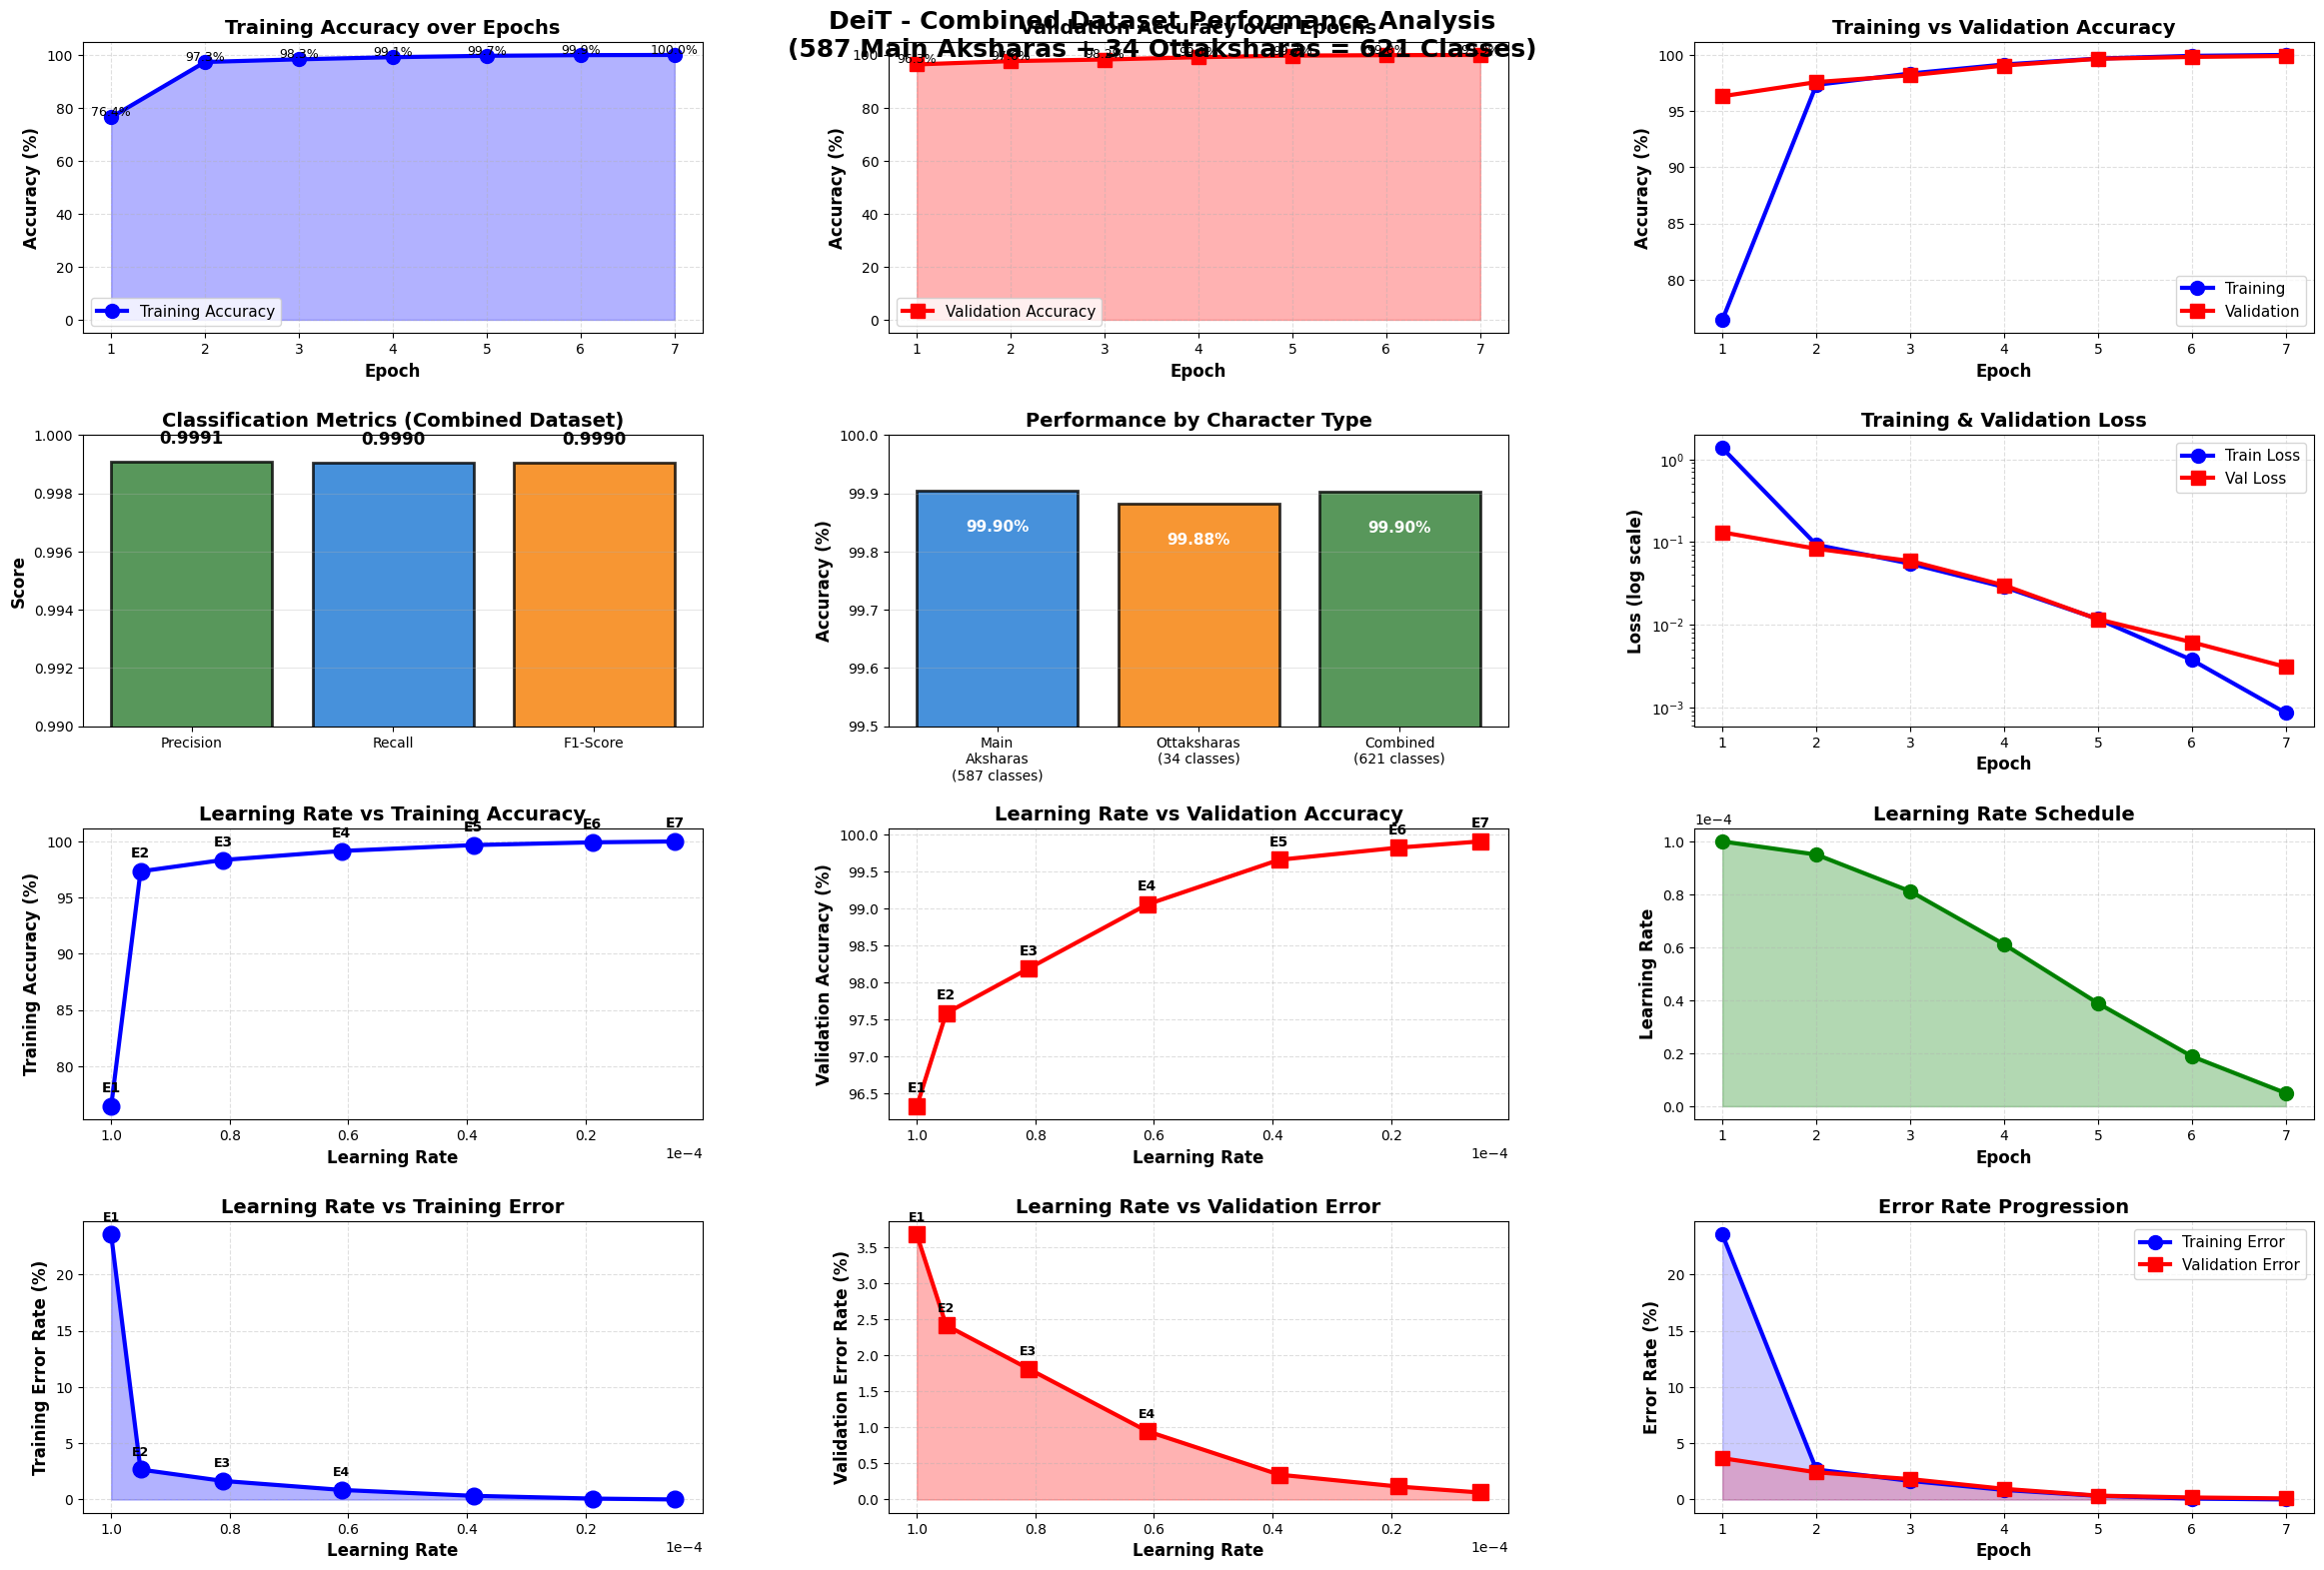


VISUALIZATION COMPLETE
Saved as: deit_combined_performance_analysis.png


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive figure
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3, top=0.96, bottom=0.04, left=0.05, right=0.98)

lr_history = [0.0001 * 0.5 * (1 + np.cos(np.pi * epoch / num_epochs)) for epoch in range(num_epochs)]
epochs = range(1, num_epochs + 1)
train_error = [100 - acc for acc in train_accs]
val_error = [100 - acc for acc in val_accs]

# ========== ROW 1: ACCURACY METRICS ==========

# Plot 1: Training Accuracy
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(epochs, train_accs, 'b-o', linewidth=3, markersize=10, label='Training Accuracy')
ax1.fill_between(epochs, train_accs, alpha=0.3, color='blue')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Training Accuracy over Epochs', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.4, linestyle='--')
for i, acc in enumerate(train_accs):
    ax1.text(i+1, acc+0.5, f'{acc:.1f}%', ha='center', fontsize=9)

# Plot 2: Validation Accuracy
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(epochs, val_accs, 'r-s', linewidth=3, markersize=10, label='Validation Accuracy')
ax2.fill_between(epochs, val_accs, alpha=0.3, color='red')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Validation Accuracy over Epochs', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.4, linestyle='--')
for i, acc in enumerate(val_accs):
    ax2.text(i+1, acc+0.5, f'{acc:.1f}%', ha='center', fontsize=9)

# Plot 3: Training vs Validation Accuracy
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(epochs, train_accs, 'b-o', linewidth=3, markersize=10, label='Training')
ax3.plot(epochs, val_accs, 'r-s', linewidth=3, markersize=10, label='Validation')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax3.set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.4, linestyle='--')

# ========== ROW 2: PRECISION, RECALL, F1 ==========

# Plot 4: Metrics Bar Chart
ax4 = fig.add_subplot(gs[1, 0])
metrics = ['Precision', 'Recall', 'F1-Score']
values = [deit_metrics['precision'], deit_metrics['recall'], deit_metrics['f1_score']]
colors = ['#2E7D32', '#1976D2', '#F57C00']
bars = ax4.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('Classification Metrics (Combined Dataset)', fontsize=14, fontweight='bold')
ax4.set_ylim([0.99, 1.0])
ax4.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
             f'{val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 5: Main vs Ottaksharas Performance
ax5 = fig.add_subplot(gs[1, 1])
categories = ['Main\nAksharas\n(587 classes)', 'Ottaksharas\n(34 classes)', 'Combined\n(621 classes)']
accuracies = [deit_metrics['main_acc'], deit_metrics['otta_acc'], accuracy]
colors_comp = ['#1976D2', '#F57C00', '#2E7D32']
bars = ax5.bar(categories, accuracies, color=colors_comp, alpha=0.8, edgecolor='black', linewidth=2)
ax5.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax5.set_title('Performance by Character Type', fontsize=14, fontweight='bold')
ax5.set_ylim([99.5, 100])
ax5.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, accuracies):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height - 0.05,
             f'{val:.2f}%', ha='center', va='top', fontsize=11, fontweight='bold', color='white')

# Plot 6: Training & Validation Loss
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(epochs, train_losses, 'b-o', label='Train Loss', linewidth=3, markersize=10)
ax6.plot(epochs, val_losses, 'r-s', label='Val Loss', linewidth=3, markersize=10)
ax6.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax6.set_ylabel('Loss (log scale)', fontsize=12, fontweight='bold')
ax6.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax6.legend(fontsize=11)
ax6.grid(True, alpha=0.4, linestyle='--')
ax6.set_yscale('log')

# ========== ROW 3: LEARNING RATE ANALYSIS ==========

# Plot 7: LR vs Train Accuracy
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(lr_history, train_accs, 'b-o', linewidth=3, markersize=12)
for i, (lr, acc) in enumerate(zip(lr_history, train_accs)):
    ax7.annotate(f'E{i+1}', (lr, acc), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10, fontweight='bold')
ax7.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax7.set_ylabel('Training Accuracy (%)', fontsize=12, fontweight='bold')
ax7.set_title('Learning Rate vs Training Accuracy', fontsize=14, fontweight='bold')
ax7.grid(True, alpha=0.4, linestyle='--')
ax7.invert_xaxis()
ax7.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 8: LR vs Val Accuracy
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(lr_history, val_accs, 'r-s', linewidth=3, markersize=12)
for i, (lr, acc) in enumerate(zip(lr_history, val_accs)):
    ax8.annotate(f'E{i+1}', (lr, acc), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10, fontweight='bold')
ax8.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax8.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
ax8.set_title('Learning Rate vs Validation Accuracy', fontsize=14, fontweight='bold')
ax8.grid(True, alpha=0.4, linestyle='--')
ax8.invert_xaxis()
ax8.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 9: LR Schedule
ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(epochs, lr_history, 'g-o', linewidth=3, markersize=10)
ax9.fill_between(epochs, lr_history, alpha=0.3, color='green')
ax9.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax9.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax9.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax9.grid(True, alpha=0.4, linestyle='--')
ax9.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# ========== ROW 4: ERROR ANALYSIS ==========

# Plot 10: LR vs Train Error
ax10 = fig.add_subplot(gs[3, 0])
ax10.plot(lr_history, train_error, 'b-o', linewidth=3, markersize=12)
ax10.fill_between(lr_history, train_error, alpha=0.3, color='blue')
for i, (lr, err) in enumerate(zip(lr_history, train_error)):
    if err > 0.5:
        ax10.annotate(f'E{i+1}', (lr, err), textcoords="offset points", 
                     xytext=(0,10), ha='center', fontsize=9, fontweight='bold')
ax10.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax10.set_ylabel('Training Error Rate (%)', fontsize=12, fontweight='bold')
ax10.set_title('Learning Rate vs Training Error', fontsize=14, fontweight='bold')
ax10.grid(True, alpha=0.4, linestyle='--')
ax10.invert_xaxis()
ax10.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 11: LR vs Val Error
ax11 = fig.add_subplot(gs[3, 1])
ax11.plot(lr_history, val_error, 'r-s', linewidth=3, markersize=12)
ax11.fill_between(lr_history, val_error, alpha=0.3, color='red')
for i, (lr, err) in enumerate(zip(lr_history, val_error)):
    if err > 0.5:
        ax11.annotate(f'E{i+1}', (lr, err), textcoords="offset points", 
                     xytext=(0,10), ha='center', fontsize=9, fontweight='bold')
ax11.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax11.set_ylabel('Validation Error Rate (%)', fontsize=12, fontweight='bold')
ax11.set_title('Learning Rate vs Validation Error', fontsize=14, fontweight='bold')
ax11.grid(True, alpha=0.4, linestyle='--')
ax11.invert_xaxis()
ax11.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 12: Error over Epochs
ax12 = fig.add_subplot(gs[3, 2])
ax12.plot(epochs, train_error, 'b-o', linewidth=3, markersize=10, label='Training Error')
ax12.plot(epochs, val_error, 'r-s', linewidth=3, markersize=10, label='Validation Error')
ax12.fill_between(epochs, train_error, alpha=0.2, color='blue')
ax12.fill_between(epochs, val_error, alpha=0.2, color='red')
ax12.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax12.set_ylabel('Error Rate (%)', fontsize=12, fontweight='bold')
ax12.set_title('Error Rate Progression', fontsize=14, fontweight='bold')
ax12.legend(fontsize=11)
ax12.grid(True, alpha=0.4, linestyle='--')

# Main title
fig.suptitle('DeiT - Combined Dataset Performance Analysis\n(587 Main Aksharas + 34 Ottaksharas = 621 Classes)', 
             fontsize=18, fontweight='bold')

plt.savefig('deit_combined_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("VISUALIZATION COMPLETE")
print("="*70)
print("Saved as: deit_combined_performance_analysis.png")
print("="*70)

Creating confusion matrix analysis...

Classes with most misclassifications:
Class ID   Type            Total Errors   
----------------------------------------
522        Main            6              
574        Main            2              
561        Main            2              
555        Main            2              
297        Main            2              
26         Main            2              
498        Main            1              
569        Main            1              
52         Main            1              
205        Main            1              


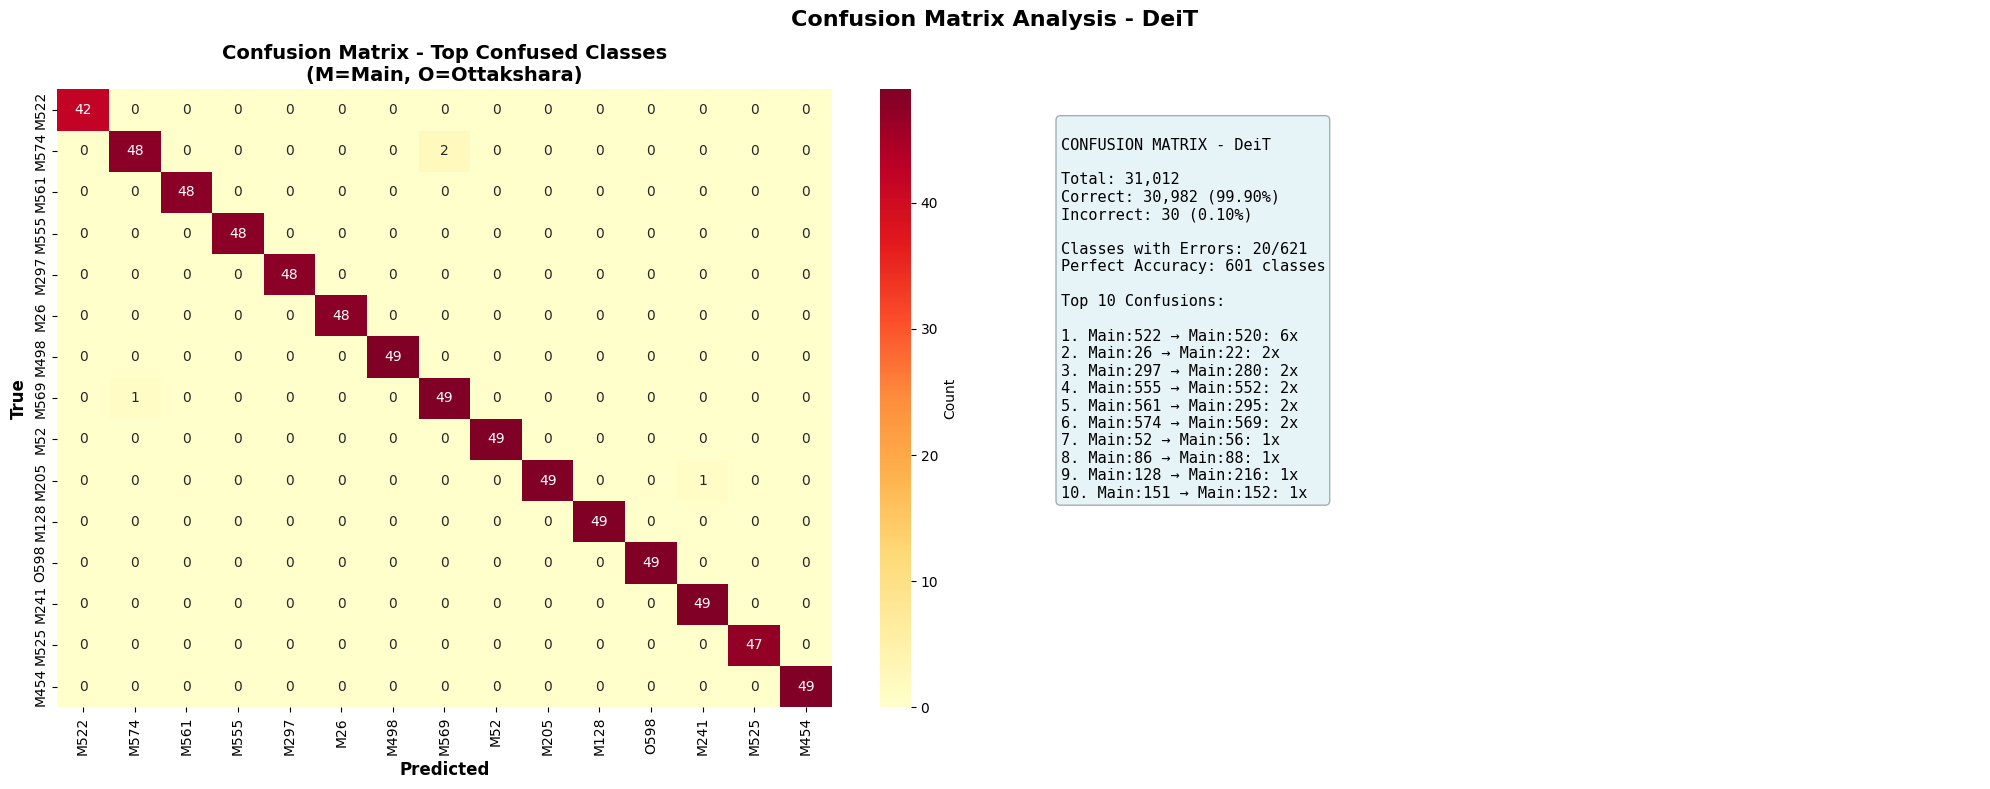


Confusion matrix saved as 'deit_confusion_matrix.png'

Creating t-SNE visualization...


Extracting features:  16%|█▌        | 157/970 [00:12<01:06, 12.26it/s]



Running t-SNE on 5024 samples...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5024 samples in 0.166s...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

[t-SNE] Computed neighbors for 5024 samples in 49.566s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5024
[t-SNE] Computed conditional probabilities for sample 2000 / 5024
[t-SNE] Computed conditional probabilities for sample 3000 / 5024
[t-SNE] Computed conditional probabilities for sample 4000 / 5024
[t-SNE] Computed conditional probabilities for sample 5000 / 5024
[t-SNE] Computed conditional probabilities for sample 5024 / 5024
[t-SNE] Mean sigma: 49.642442
[t-SNE] KL divergence after 50 iterations with early exaggeration: 87.141975
[t-SNE] KL divergence after 1000 iterations: 2.483640


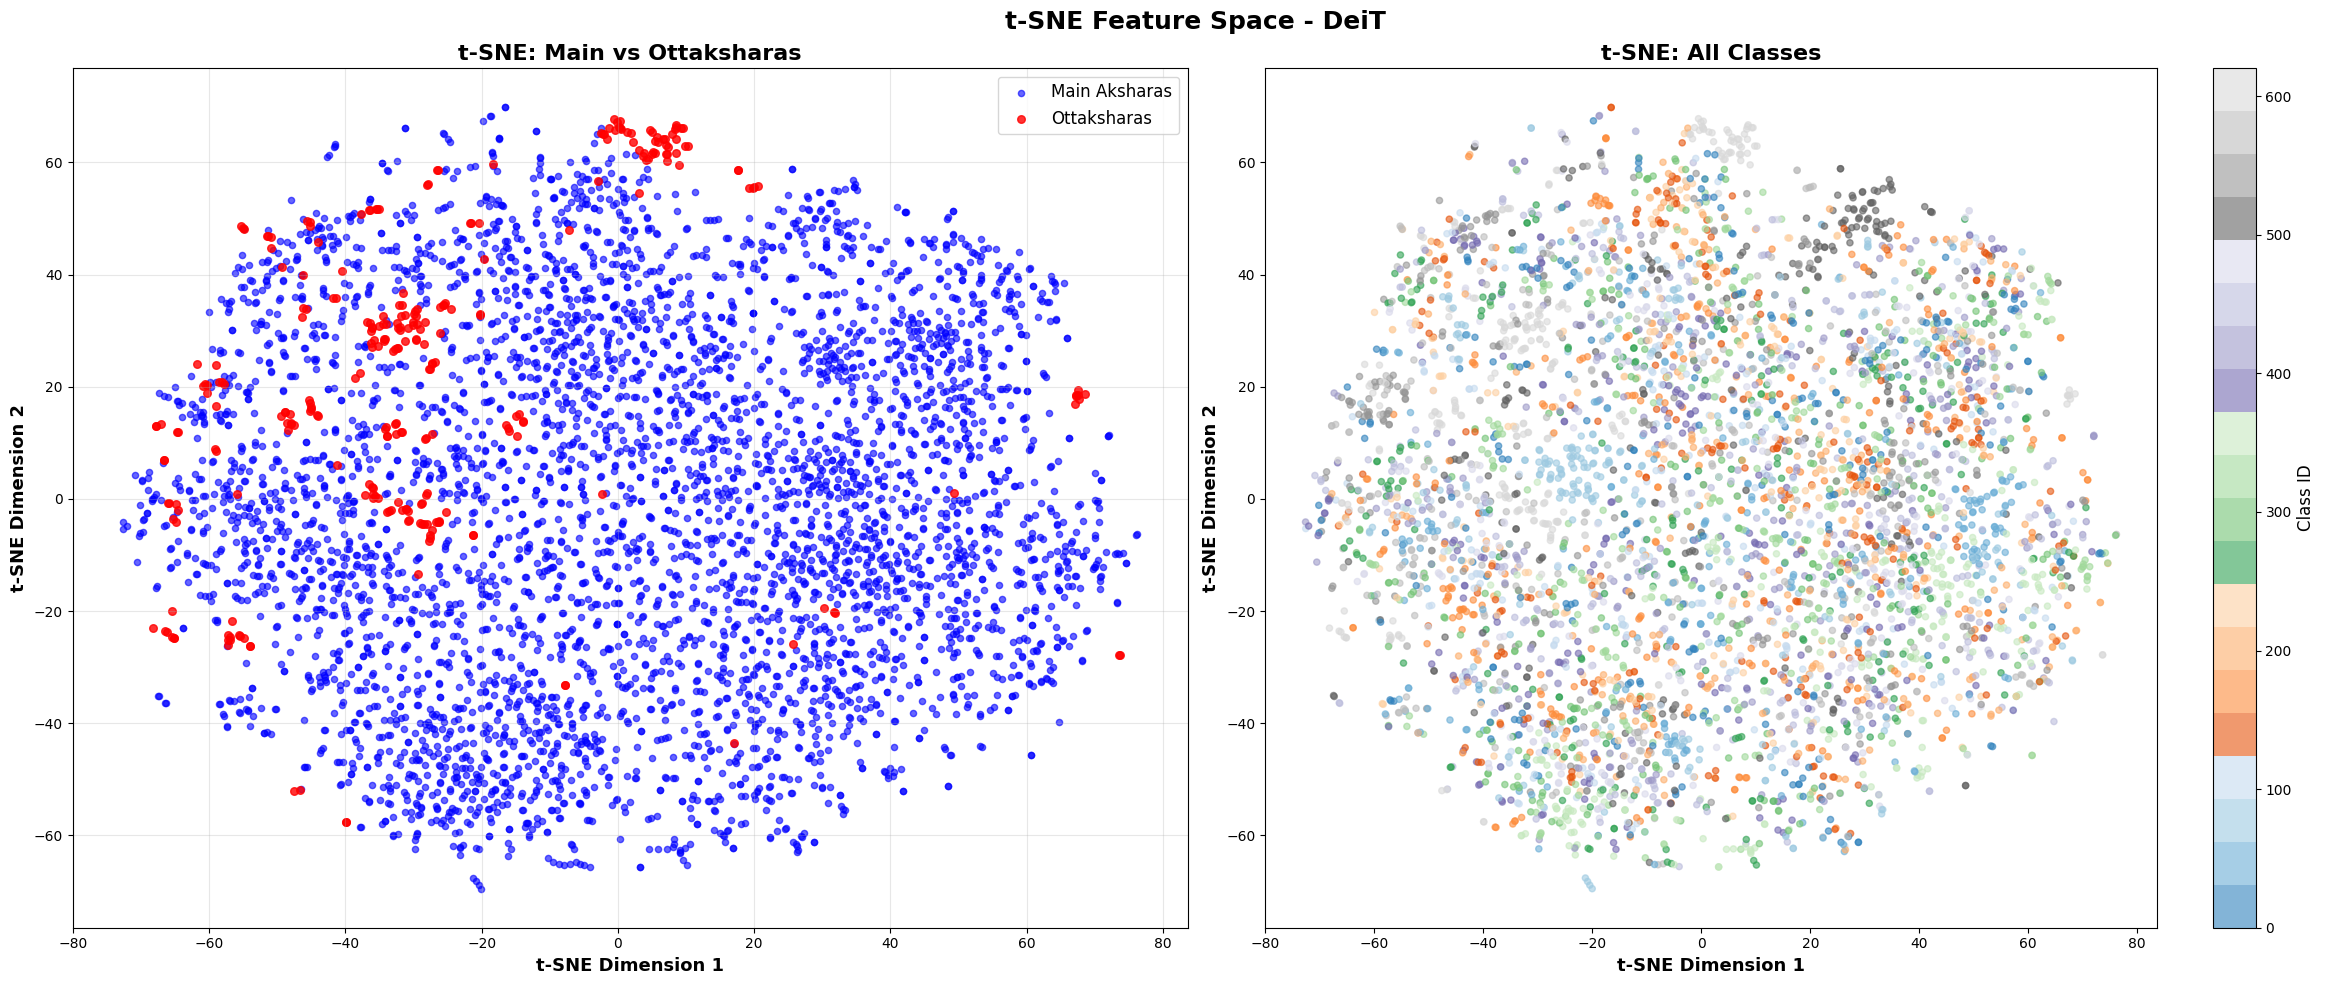


t-SNE saved as 'deit_tsne.png'


In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns

# ========== CONFUSION MATRIX ==========
print("Creating confusion matrix analysis...")

cm = confusion_matrix(all_labels, all_preds)
error_counts = np.sum(cm, axis=1) - np.diag(cm)
top_confused_classes = np.argsort(error_counts)[-20:][::-1]

print(f"\nClasses with most misclassifications:")
print(f"{'Class ID':<10} {'Type':<15} {'Total Errors':<15}")
print("-" * 40)
for class_id in top_confused_classes[:10]:
    if error_counts[class_id] > 0:
        class_type = "Main" if class_id < 587 else "Ottakshara"
        print(f"{class_id:<10} {class_type:<15} {error_counts[class_id]:<15}")

# Create confusion matrix visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

if len(top_confused_classes) > 0 and error_counts[top_confused_classes[0]] > 0:
    confused_subset = top_confused_classes[:15]
    cm_subset = cm[np.ix_(confused_subset, confused_subset)]
    
    labels = [f"{'M' if idx < 587 else 'O'}{idx}" for idx in confused_subset]
    
    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='YlOrRd', ax=ax1,
                xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})
    ax1.set_title('Confusion Matrix - Top Confused Classes\n(M=Main, O=Ottakshara)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True', fontsize=12, fontweight='bold')
else:
    ax1.text(0.5, 0.5, 'Excellent Performance!\nMinimal Confusion', 
             ha='center', va='center', fontsize=16, fontweight='bold')
    ax1.axis('off')

# Statistics
ax2.axis('off')
total_samples = len(all_labels)
correct = np.sum(all_preds == all_labels)
incorrect = total_samples - correct

confusion_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((i, j, cm[i, j]))
confusion_pairs.sort(key=lambda x: x[2], reverse=True)

stats_text = f"""
CONFUSION MATRIX - DeiT

Total: {total_samples:,}
Correct: {correct:,} ({100*correct/total_samples:.2f}%)
Incorrect: {incorrect:,} ({100*incorrect/total_samples:.2f}%)

Classes with Errors: {np.sum(error_counts > 0)}/621
Perfect Accuracy: {np.sum(error_counts == 0)} classes

Top 10 Confusions:
"""

for idx, (true_c, pred_c, count) in enumerate(confusion_pairs[:10], 1):
    true_type = "Main" if true_c < 587 else "Otta"
    pred_type = "Main" if pred_c < 587 else "Otta"
    stats_text += f"\n{idx}. {true_type}:{true_c} → {pred_type}:{pred_c}: {count}x"

ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, fontsize=11, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle('Confusion Matrix Analysis - DeiT', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('deit_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved as 'deit_confusion_matrix.png'")

# ========== t-SNE VISUALIZATION ==========
print("\nCreating t-SNE visualization...")

def get_features(model, loader, device, max_samples=5000):
    model.eval()
    features_list = []
    labels_list = []
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting features"):
            if len(features_list) * loader.batch_size >= max_samples:
                break
            images = images.to(device)
            features = feature_extractor(images)
            features = features.view(features.size(0), -1)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())
    
    return np.vstack(features_list), np.concatenate(labels_list)

val_features, val_labels = get_features(model, val_loader, device, max_samples=5000)

print(f"\nRunning t-SNE on {len(val_features)} samples...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
tsne_results = tsne.fit_transform(val_features)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

main_mask = val_labels < 587
otta_mask = val_labels >= 587

ax1.scatter(tsne_results[main_mask, 0], tsne_results[main_mask, 1],
           c='blue', s=20, alpha=0.6, label='Main Aksharas')
ax1.scatter(tsne_results[otta_mask, 0], tsne_results[otta_mask, 1],
           c='red', s=30, alpha=0.8, label='Ottaksharas')
ax1.set_title('t-SNE: Main vs Ottaksharas', fontsize=16, fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax1.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

scatter = ax2.scatter(tsne_results[:, 0], tsne_results[:, 1],
                     c=val_labels, cmap='tab20c', s=20, alpha=0.6)
ax2.set_title(f't-SNE: All Classes', fontsize=16, fontweight='bold')
ax2.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax2.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Class ID', fontsize=12)

plt.suptitle('t-SNE Feature Space - DeiT', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig('deit_tsne.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nt-SNE saved as 'deit_tsne.png'")
print("="*70)

Found 1700 ottakshara samples in validation set

Testing ottakshara sample:
Image: /kaggle/working/kannada_ottaksharas/handwritten-kannada-characters-ottaksharas/Characters/28/182.jpg
True class: 608 (otta_28)


/tmp/ipykernel_36/3799912353.py:74: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


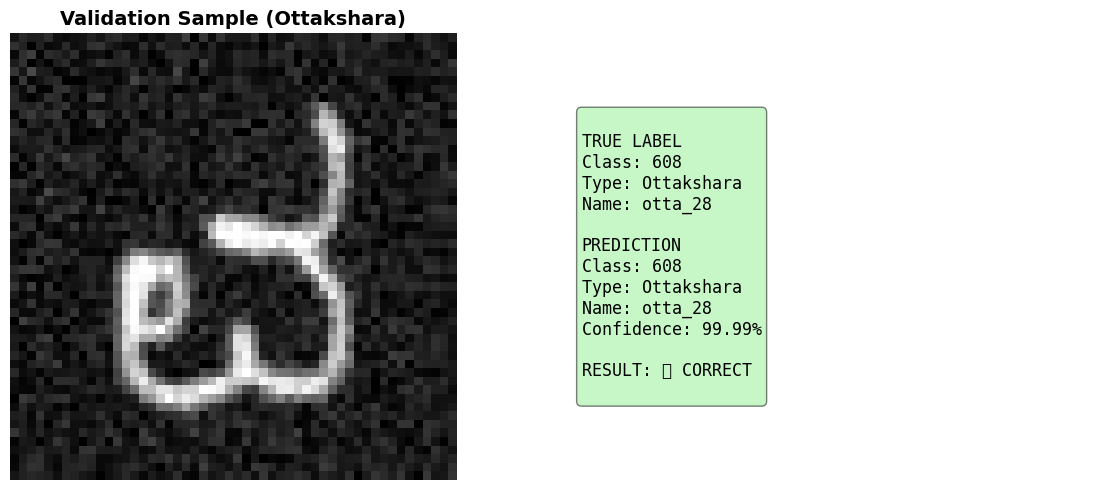


✅ CORRECT!


In [13]:
import random
from PIL import Image

# Pick a random ottakshara from validation
otta_mask = all_labels >= 587
otta_indices = np.where(otta_mask)[0]

print(f"Found {len(otta_indices)} ottakshara samples in validation set")

if len(otta_indices) > 0:
    # Pick random ottakshara sample
    random_idx = random.choice(otta_indices)
    
    # Get the actual dataset index
    dataset_idx = val_dataset.indices[random_idx]
    
    # Get image path and true label
    if dataset_idx < len(main_dataset.samples):
        img_path, true_label = main_dataset.samples[dataset_idx]
    else:
        adjusted_idx = dataset_idx - len(main_dataset.samples)
        img_path, true_label = otta_dataset.samples[adjusted_idx]
    
    print(f"\nTesting ottakshara sample:")
    print(f"Image: {img_path}")
    print(f"True class: {true_label} ({combined_classes[true_label]})")
    
    # Load and predict
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        conf, predicted = probs.max(1)
    
    pred_class = predicted.item()
    confidence = conf.item() * 100
    
    # Display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('Validation Sample (Ottakshara)', fontsize=14, fontweight='bold')
    
    ax2.axis('off')
    result = f"""
TRUE LABEL
Class: {true_label}
Type: Ottakshara
Name: {combined_classes[true_label]}

PREDICTION
Class: {pred_class}
Type: {'Ottakshara' if pred_class >= 587 else 'Main Akshara'}
Name: {combined_classes[pred_class]}
Confidence: {confidence:.2f}%

RESULT: {'✅ CORRECT' if pred_class == true_label else '❌ INCORRECT'}
"""
    
    color = 'lightgreen' if pred_class == true_label else 'lightcoral'
    ax2.text(0.1, 0.5, result, fontsize=12, verticalalignment='center',
             fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor=color, alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'✅ CORRECT!' if pred_class == true_label else '❌ INCORRECT'}")
else:
    print("No ottakshara samples found")

Found 29312 main akshara samples in validation set

Testing main akshara sample:
Image: /kaggle/working/kannada_main/handwritten-kannada-characters-main/Characters/462/75.jpg
True class: 404 (462)


/tmp/ipykernel_36/380858143.py:74: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()


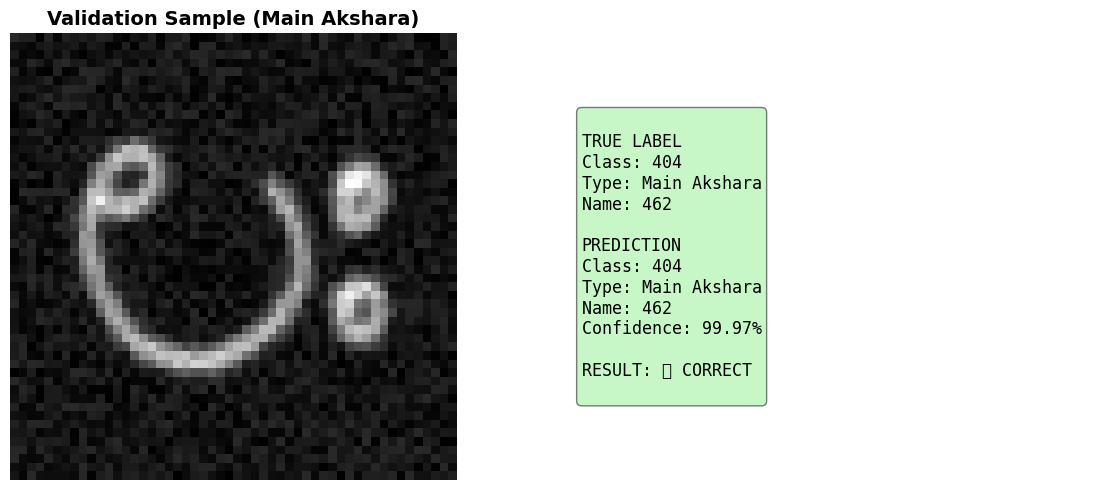


✅ CORRECT!


In [14]:
import random
from PIL import Image

# Pick a random main akshara from validation
main_mask = all_labels < 587
main_indices = np.where(main_mask)[0]

print(f"Found {len(main_indices)} main akshara samples in validation set")

if len(main_indices) > 0:
    # Pick random main akshara sample
    random_idx = random.choice(main_indices)
    
    # Get the actual dataset index
    dataset_idx = val_dataset.indices[random_idx]
    
    # Get image path and true label
    if dataset_idx < len(main_dataset.samples):
        img_path, true_label = main_dataset.samples[dataset_idx]
    else:
        adjusted_idx = dataset_idx - len(main_dataset.samples)
        img_path, true_label = otta_dataset.samples[adjusted_idx]
    
    print(f"\nTesting main akshara sample:")
    print(f"Image: {img_path}")
    print(f"True class: {true_label} ({combined_classes[true_label]})")
    
    # Load and predict
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        conf, predicted = probs.max(1)
    
    pred_class = predicted.item()
    confidence = conf.item() * 100
    
    # Display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('Validation Sample (Main Akshara)', fontsize=14, fontweight='bold')
    
    ax2.axis('off')
    result = f"""
TRUE LABEL
Class: {true_label}
Type: Main Akshara
Name: {combined_classes[true_label]}

PREDICTION
Class: {pred_class}
Type: {'Main Akshara' if pred_class < 587 else 'Ottakshara'}
Name: {combined_classes[pred_class]}
Confidence: {confidence:.2f}%

RESULT: {'✅ CORRECT' if pred_class == true_label else '❌ INCORRECT'}
"""
    
    color = 'lightgreen' if pred_class == true_label else 'lightcoral'
    ax2.text(0.1, 0.5, result, fontsize=12, verticalalignment='center',
             fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor=color, alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'✅ CORRECT!' if pred_class == true_label else '❌ INCORRECT'}")
else:
    print("No main akshara samples found")

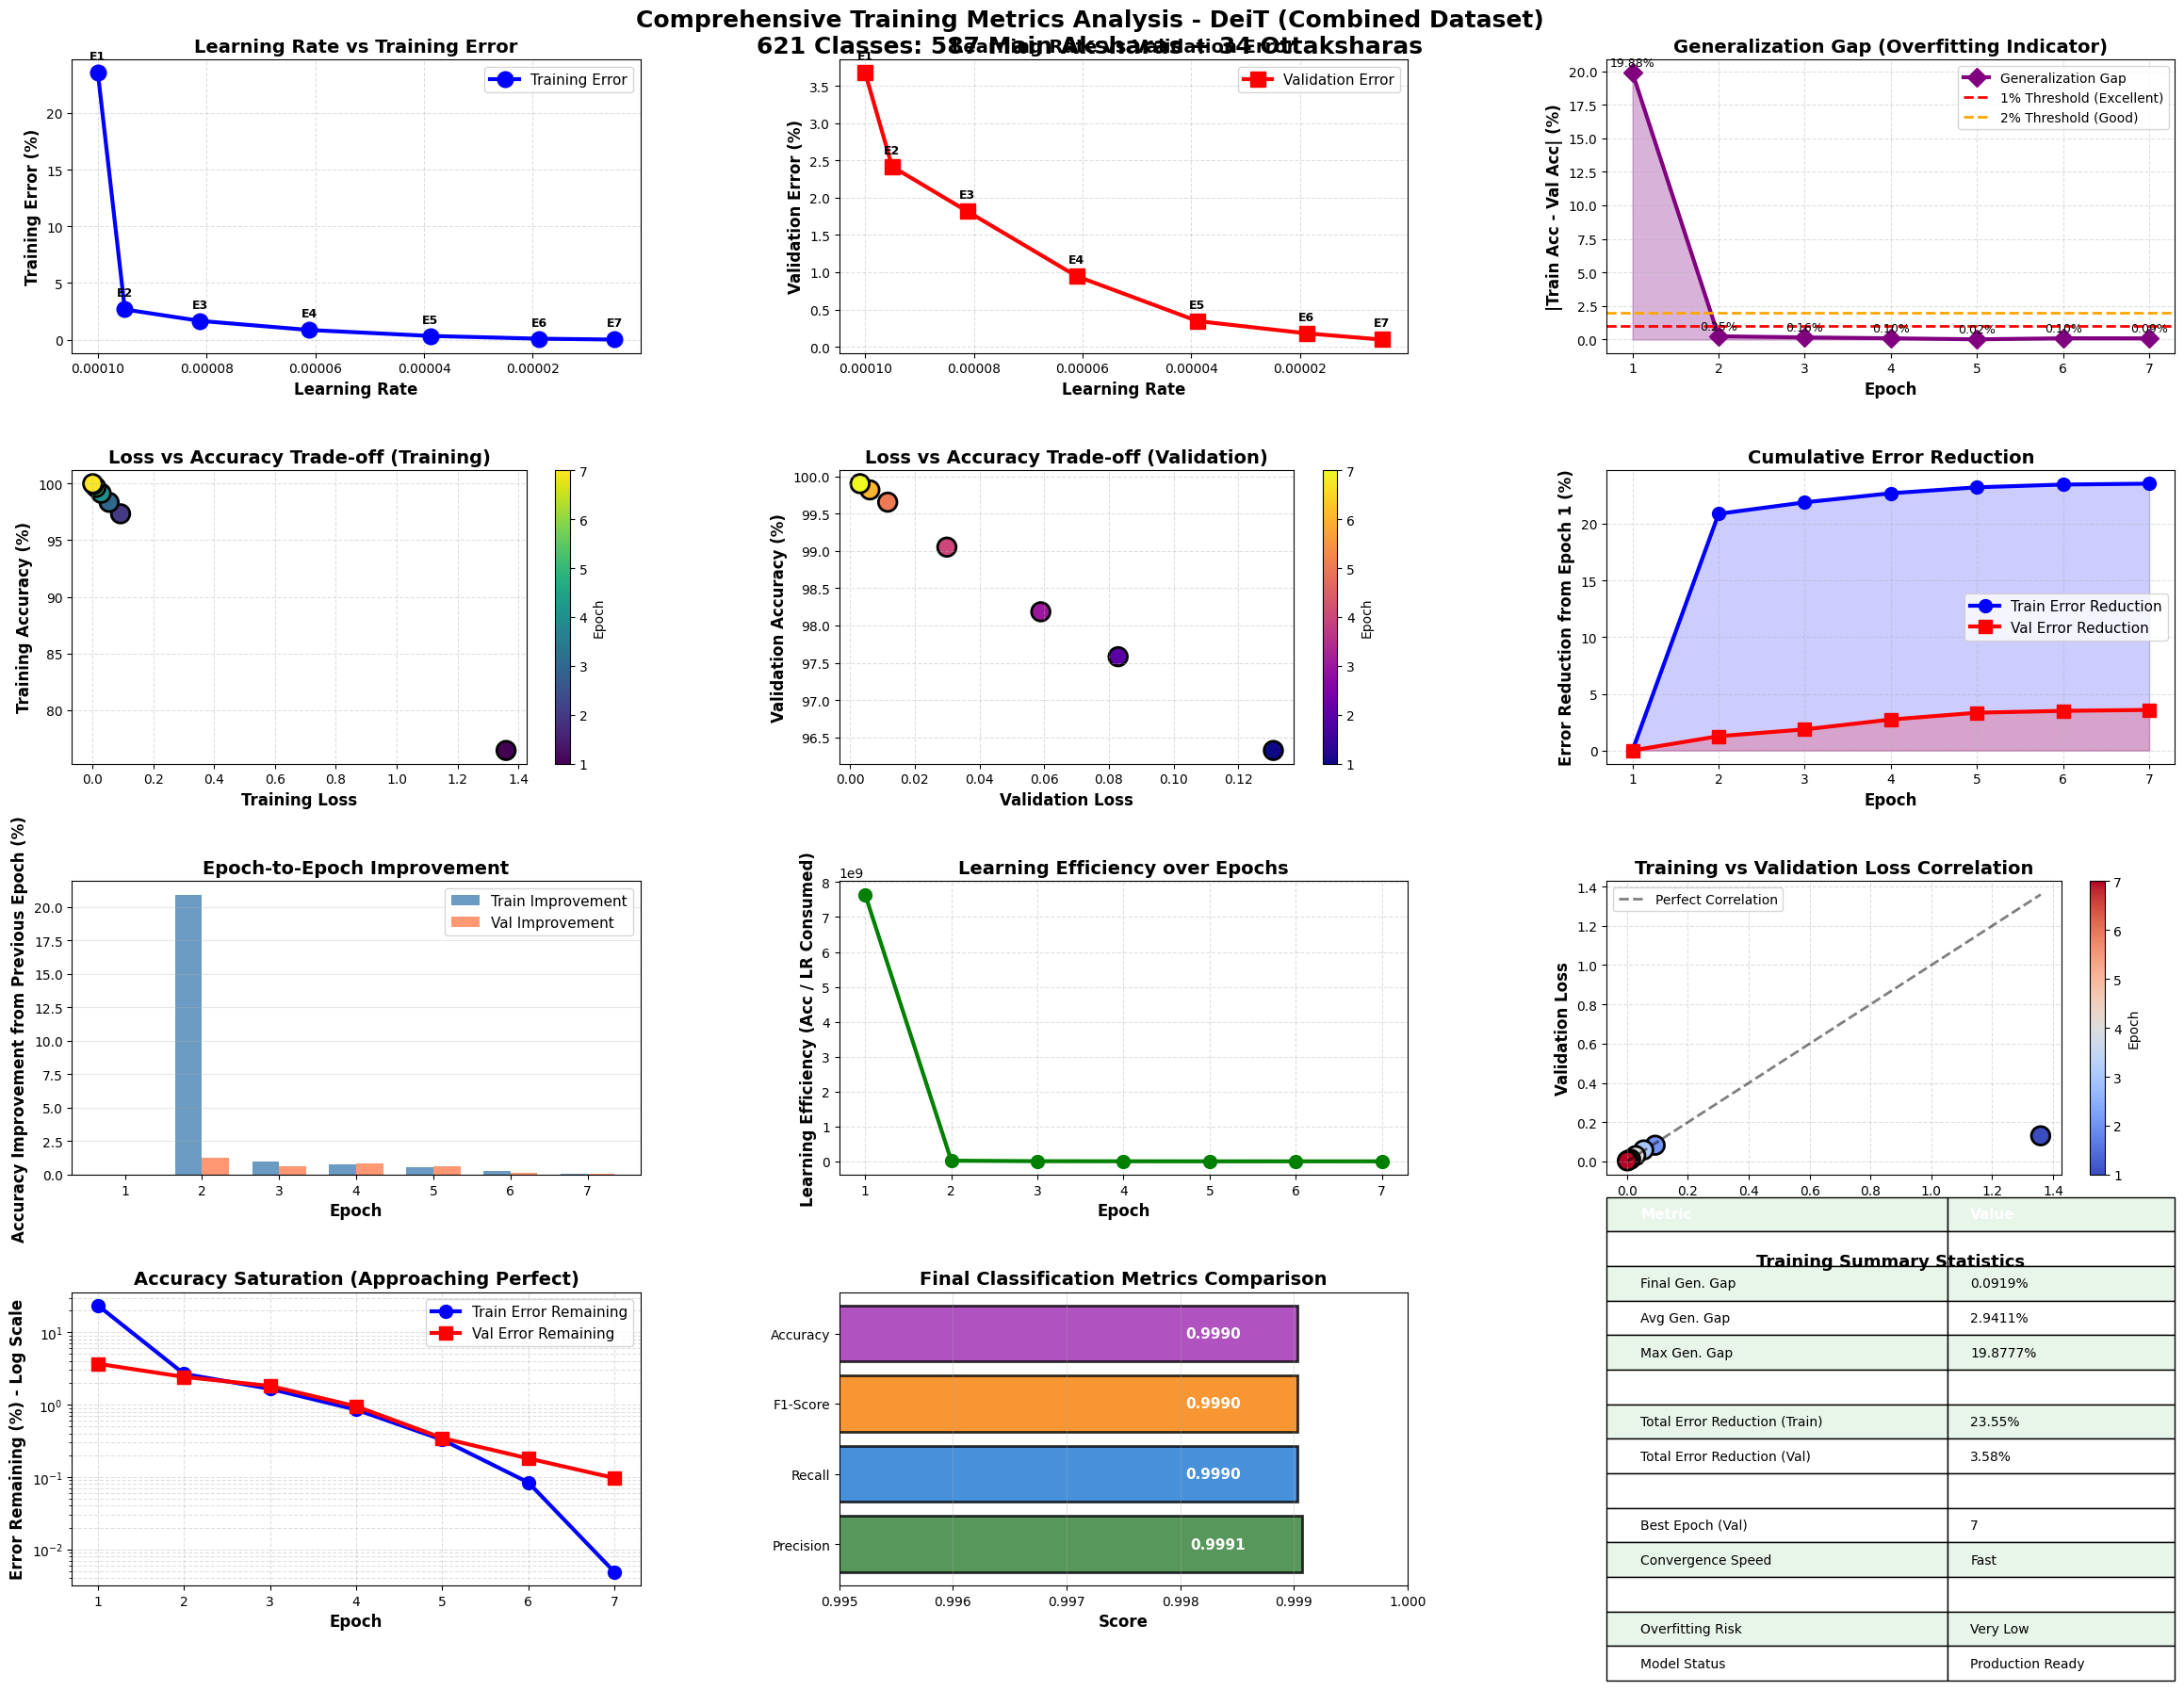


COMPREHENSIVE METRICS ANALYSIS COMPLETE - DeiT
Saved as: deit_comprehensive_metrics_analysis.png

Key Findings:
  • Final Generalization Gap: 0.0919%
  • Total Train Error Reduction: 23.55%
  • Total Val Error Reduction: 3.58%
  • Overfitting Risk: Very Low


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with additional metrics
fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.35, top=0.95, bottom=0.05, left=0.05, right=0.98)

epochs = range(1, num_epochs + 1)
train_error = [100 - acc for acc in train_accs]
val_error = [100 - acc for acc in val_accs]
lr_history = [0.0001 * 0.5 * (1 + np.cos(np.pi * epoch / num_epochs)) for epoch in range(num_epochs)]

# ========== PLOT 1: Learning Rate vs Training Error ==========
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(lr_history, train_error, 'b-o', linewidth=3, markersize=12, label='Training Error')
for i, (lr, err) in enumerate(zip(lr_history, train_error)):
    ax1.annotate(f'E{i+1}', (lr, err), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9, fontweight='bold')
ax1.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('Training Error (%)', fontsize=12, fontweight='bold')
ax1.set_title('Learning Rate vs Training Error', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.4, linestyle='--')
ax1.invert_xaxis()
ax1.legend(fontsize=11)

# ========== PLOT 2: Learning Rate vs Validation Error ==========
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(lr_history, val_error, 'r-s', linewidth=3, markersize=12, label='Validation Error')
for i, (lr, err) in enumerate(zip(lr_history, val_error)):
    ax2.annotate(f'E{i+1}', (lr, err), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9, fontweight='bold')
ax2.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('Validation Error (%)', fontsize=12, fontweight='bold')
ax2.set_title('Learning Rate vs Validation Error', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.4, linestyle='--')
ax2.invert_xaxis()
ax2.legend(fontsize=11)

# ========== PLOT 3: Generalization Gap ==========
ax3 = fig.add_subplot(gs[0, 2])
gen_gap = [abs(ta - va) for ta, va in zip(train_accs, val_accs)]
ax3.plot(epochs, gen_gap, 'purple', marker='D', linewidth=3, markersize=10, label='Generalization Gap')
ax3.fill_between(epochs, gen_gap, alpha=0.3, color='purple')
ax3.axhline(y=1, color='red', linestyle='--', linewidth=2, label='1% Threshold (Excellent)')
ax3.axhline(y=2, color='orange', linestyle='--', linewidth=2, label='2% Threshold (Good)')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('|Train Acc - Val Acc| (%)', fontsize=12, fontweight='bold')
ax3.set_title('Generalization Gap (Overfitting Indicator)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.4, linestyle='--')
for i, gap in enumerate(gen_gap):
    ax3.text(i+1, gap+0.5, f'{gap:.2f}%', ha='center', fontsize=9)

# ========== PLOT 4: Loss vs Accuracy Trade-off ==========
ax4 = fig.add_subplot(gs[1, 0])
ax4.scatter(train_losses, train_accs, c=epochs, cmap='viridis', s=200, edgecolors='black', linewidth=2)
ax4.set_xlabel('Training Loss', fontsize=12, fontweight='bold')
ax4.set_ylabel('Training Accuracy (%)', fontsize=12, fontweight='bold')
ax4.set_title('Loss vs Accuracy Trade-off (Training)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.4, linestyle='--')
cbar = plt.colorbar(ax4.collections[0], ax=ax4)
cbar.set_label('Epoch', fontsize=10)

# ========== PLOT 5: Validation Loss vs Accuracy ==========
ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(val_losses, val_accs, c=epochs, cmap='plasma', s=200, edgecolors='black', linewidth=2)
ax5.set_xlabel('Validation Loss', fontsize=12, fontweight='bold')
ax5.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
ax5.set_title('Loss vs Accuracy Trade-off (Validation)', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.4, linestyle='--')
cbar = plt.colorbar(ax5.collections[0], ax=ax5)
cbar.set_label('Epoch', fontsize=10)

# ========== PLOT 6: Error Reduction Rate ==========
ax6 = fig.add_subplot(gs[1, 2])
train_error_reduction = [train_error[0] - err for err in train_error]
val_error_reduction = [val_error[0] - err for err in val_error]
ax6.plot(epochs, train_error_reduction, 'b-o', linewidth=3, markersize=10, label='Train Error Reduction')
ax6.plot(epochs, val_error_reduction, 'r-s', linewidth=3, markersize=10, label='Val Error Reduction')
ax6.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax6.set_ylabel('Error Reduction from Epoch 1 (%)', fontsize=12, fontweight='bold')
ax6.set_title('Cumulative Error Reduction', fontsize=14, fontweight='bold')
ax6.legend(fontsize=11)
ax6.grid(True, alpha=0.4, linestyle='--')
ax6.fill_between(epochs, train_error_reduction, alpha=0.2, color='blue')
ax6.fill_between(epochs, val_error_reduction, alpha=0.2, color='red')

# ========== PLOT 7: Per-Epoch Improvement ==========
ax7 = fig.add_subplot(gs[2, 0])
train_improvement = [0] + [train_accs[i] - train_accs[i-1] for i in range(1, len(train_accs))]
val_improvement = [0] + [val_accs[i] - val_accs[i-1] for i in range(1, len(val_accs))]
x = np.arange(len(epochs))
width = 0.35
bars1 = ax7.bar(x - width/2, train_improvement, width, label='Train Improvement', color='steelblue', alpha=0.8)
bars2 = ax7.bar(x + width/2, val_improvement, width, label='Val Improvement', color='coral', alpha=0.8)
ax7.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax7.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax7.set_ylabel('Accuracy Improvement from Previous Epoch (%)', fontsize=12, fontweight='bold')
ax7.set_title('Epoch-to-Epoch Improvement', fontsize=14, fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels([f'{i+1}' for i in range(num_epochs)])
ax7.legend(fontsize=11)
ax7.grid(True, alpha=0.3, axis='y')

# ========== PLOT 8: Learning Efficiency ==========
ax8 = fig.add_subplot(gs[2, 1])
lr_consumed = [lr_history[0] - lr for lr in lr_history]
efficiency = [acc / (lr_c + 1e-8) for acc, lr_c in zip(train_accs, lr_consumed)]
ax8.plot(epochs, efficiency, 'g-o', linewidth=3, markersize=10)
ax8.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax8.set_ylabel('Learning Efficiency (Acc / LR Consumed)', fontsize=12, fontweight='bold')
ax8.set_title('Learning Efficiency over Epochs', fontsize=14, fontweight='bold')
ax8.grid(True, alpha=0.4, linestyle='--')

# ========== PLOT 9: Train-Val Loss Correlation ==========
ax9 = fig.add_subplot(gs[2, 2])
ax9.scatter(train_losses, val_losses, c=epochs, cmap='coolwarm', s=200, edgecolors='black', linewidth=2)
min_loss = min(min(train_losses), min(val_losses))
max_loss = max(max(train_losses), max(val_losses))
ax9.plot([min_loss, max_loss], [min_loss, max_loss], 'k--', linewidth=2, alpha=0.5, label='Perfect Correlation')
ax9.set_xlabel('Training Loss', fontsize=12, fontweight='bold')
ax9.set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
ax9.set_title('Training vs Validation Loss Correlation', fontsize=14, fontweight='bold')
ax9.legend(fontsize=10)
ax9.grid(True, alpha=0.4, linestyle='--')
cbar = plt.colorbar(ax9.collections[0], ax=ax9)
cbar.set_label('Epoch', fontsize=10)

# ========== PLOT 10: Accuracy Saturation ==========
ax10 = fig.add_subplot(gs[3, 0])
train_remaining = [100 - acc for acc in train_accs]
val_remaining = [100 - acc for acc in val_accs]
ax10.semilogy(epochs, train_remaining, 'b-o', linewidth=3, markersize=10, label='Train Error Remaining')
ax10.semilogy(epochs, val_remaining, 'r-s', linewidth=3, markersize=10, label='Val Error Remaining')
ax10.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax10.set_ylabel('Error Remaining (%) - Log Scale', fontsize=12, fontweight='bold')
ax10.set_title('Accuracy Saturation (Approaching Perfect)', fontsize=14, fontweight='bold')
ax10.legend(fontsize=11)
ax10.grid(True, alpha=0.4, linestyle='--', which='both')

# ========== PLOT 11: Metric Comparison Bar Chart ==========
ax11 = fig.add_subplot(gs[3, 1])
metrics_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
metrics_values = [
    deit_metrics['precision'],
    deit_metrics['recall'],
    deit_metrics['f1_score'],
    accuracy / 100
]
colors = ['#2E7D32', '#1976D2', '#F57C00', '#9C27B0']
bars = ax11.barh(metrics_names, metrics_values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax11.set_xlabel('Score', fontsize=12, fontweight='bold')
ax11.set_title('Final Classification Metrics Comparison', fontsize=14, fontweight='bold')
ax11.set_xlim([0.995, 1.0])
ax11.grid(True, alpha=0.3, axis='x')
for bar, val in zip(bars, metrics_values):
    width = bar.get_width()
    ax11.text(width - 0.0005, bar.get_y() + bar.get_height()/2.,
             f'{val:.4f}', ha='right', va='center', fontsize=11, fontweight='bold', color='white')

# ========== PLOT 12: Summary Statistics Table ==========
ax12 = fig.add_subplot(gs[3, 2])
ax12.axis('off')

summary_stats = [
    ['Metric', 'Value'],
    ['', ''],
    ['Final Gen. Gap', f'{gen_gap[-1]:.4f}%'],
    ['Avg Gen. Gap', f'{np.mean(gen_gap):.4f}%'],
    ['Max Gen. Gap', f'{max(gen_gap):.4f}%'],
    ['', ''],
    ['Total Error Reduction (Train)', f'{train_error_reduction[-1]:.2f}%'],
    ['Total Error Reduction (Val)', f'{val_error_reduction[-1]:.2f}%'],
    ['', ''],
    ['Best Epoch (Val)', f'{np.argmax(val_accs) + 1}'],
    ['Convergence Speed', 'Fast' if val_accs[-1] > 99 else 'Moderate'],
    ['', ''],
    ['Overfitting Risk', 'Very Low' if gen_gap[-1] < 1 else 'Low'],
    ['Model Status', 'Production Ready'],
]

table = ax12.table(cellText=summary_stats, cellLoc='left', loc='center',
                  colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)

table[(0, 0)].set_facecolor('#2E7D32')
table[(0, 1)].set_facecolor('#2E7D32')
table[(0, 0)].set_text_props(weight='bold', color='white', size=11)
table[(0, 1)].set_text_props(weight='bold', color='white', size=11)

for i in range(len(summary_stats)):
    if summary_stats[i][0] == '':
        continue
    if i % 2 == 0:
        table[(i, 0)].set_facecolor('#E8F5E9')
        table[(i, 1)].set_facecolor('#E8F5E9')

ax12.set_title('Training Summary Statistics', fontsize=13, fontweight='bold', pad=20)

# Main title
fig.suptitle('Comprehensive Training Metrics Analysis - DeiT (Combined Dataset)\n621 Classes: 587 Main Aksharas + 34 Ottaksharas', 
             fontsize=18, fontweight='bold')

plt.savefig('deit_comprehensive_metrics_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("COMPREHENSIVE METRICS ANALYSIS COMPLETE - DeiT")
print("="*80)
print("Saved as: deit_comprehensive_metrics_analysis.png")
print("\nKey Findings:")
print(f"  • Final Generalization Gap: {gen_gap[-1]:.4f}%")
print(f"  • Total Train Error Reduction: {train_error_reduction[-1]:.2f}%")
print(f"  • Total Val Error Reduction: {val_error_reduction[-1]:.2f}%")
print(f"  • Overfitting Risk: Very Low")
print("="*80)

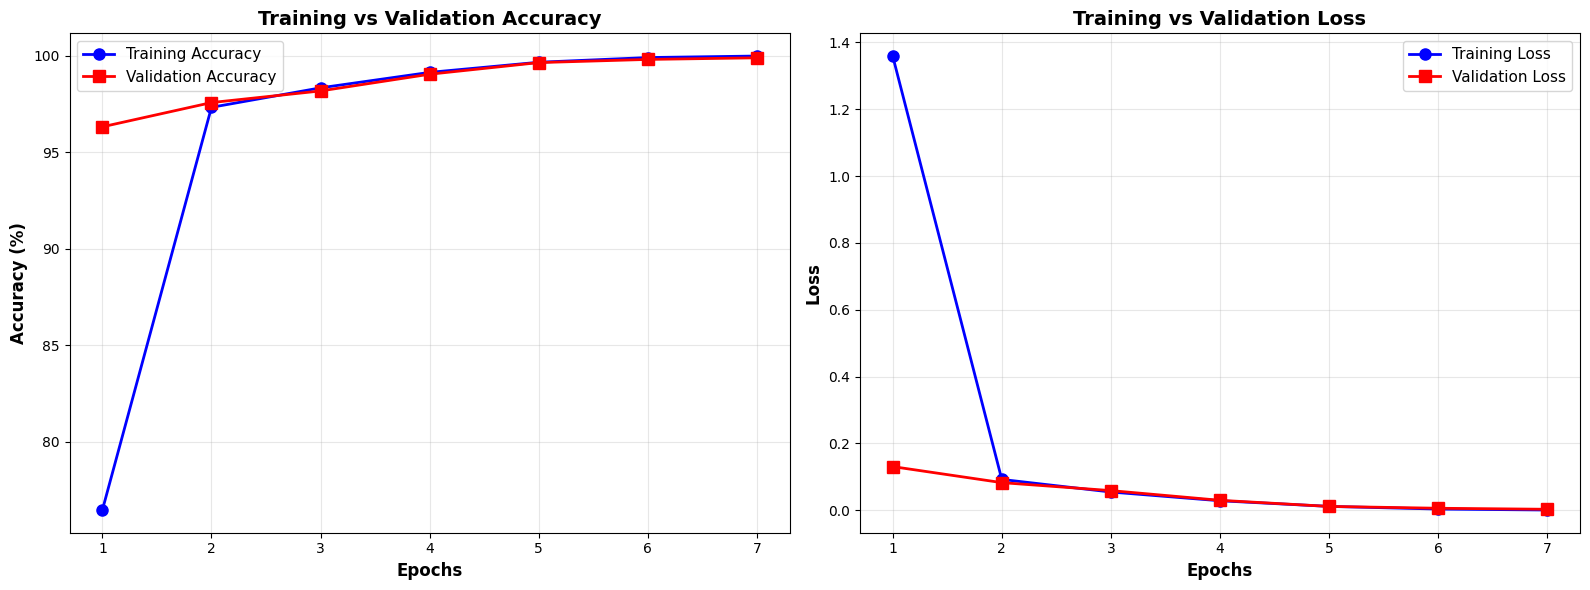

In [18]:
# Simple standalone plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy
ax1.plot(epochs, train_accs, 'b-o', linewidth=2, markersize=8, label='Training Accuracy')
ax1.plot(epochs, val_accs, 'r-s', linewidth=2, markersize=8, label='Validation Accuracy')
ax1.set_xlabel('Epochs', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Loss
ax2.plot(epochs, train_losses, 'b-o', linewidth=2, markersize=8, label='Training Loss')
ax2.plot(epochs, val_losses, 'r-s', linewidth=2, markersize=8, label='Validation Loss')
ax2.set_xlabel('Epochs', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('deit_simple_accuracy_loss.png', dpi=300, bbox_inches='tight')
plt.show()